In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter

CUDA_LAUNCH_BLOCKING=1

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
# Mount
drive.mount('/content/gdrive', force_remount=True)
data_dir_drive ='/content/gdrive/My Drive/Colab Notebooks/Project'
data_dir ='/content' # When read from unziped file

Mounted at /content/gdrive


In [0]:
# Unzip dataset to /content
import time

start = time.time()

!unzip -q '/content/gdrive/My Drive/Colab Notebooks/Project/zip/resized.zip'

print('Took', (time.time() - start), ' secundes to unzip')

"""# Uncomment when unzipping to drive, not to /content
import os
os.listdir()
os.chdir('gdrive/My Drive/google-landmark-recognition-project/')
os.listdir()
"""

# **Dataset loader**
The dataset is divided in three categories: training, validation and test.

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

Note: These three sets should all contain different images.

Loading this dataset with pytorch is really easy using ImageFolder as the labels are specified by the folders names.

In [3]:
TRAIN = 'train'
VAL = 'val'
TEST = 'test'
BATCHSIZE = 32

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.25),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCHSIZE,
        shuffle=True, num_workers=32
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
total = dataset_sizes[TRAIN] + dataset_sizes[VAL] + dataset_sizes[TEST]

for x in [TRAIN, VAL, TEST]: 
    print("Loaded {} images under {} ({}%)".format(dataset_sizes[x], x, dataset_sizes[x] * 100 / total))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 123391 images under train (69.99359007084958%)
Loaded 26443 images under val (14.999801462371448%)
Loaded 26455 images under test (15.006608466778982%)
Classes: 
['10045', '10184', '10900', '11784', '12172', '12220', '12718', '13526', '1553', '2061', '2338', '2743', '2949', '3804', '3924', '428', '4352', '4987', '5376', '5554', '6651', '6696', '7092', '8063', '8429', '9029', '9779']


In [5]:
start = time.time()
inputs, classes = next(iter(dataloaders[TRAIN]))
print(time.time() - start, 'seconds')

7.873148441314697 seconds


In [6]:
for x in [TRAIN, VAL, TEST]: 
    print("Number of batches per {} = {}".format(x.upper(), len(dataloaders[x])))

Number of batches per TRAIN = 3856
Number of batches per VAL = 827
Number of batches per TEST = 827


# **Utils**
Some utility function to visualize the dataset and the model's predictions

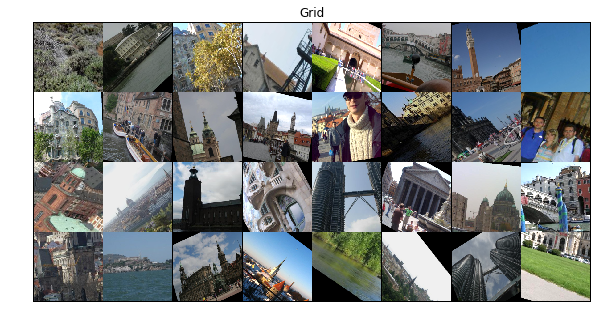

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title='Grid') #[class_names[x] for x in classes]

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [0]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        with torch.no_grad():
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
        
            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

This helper function will give us the accuracy of our model on the test set.


In [0]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 20)
    
    acc_test_intermediar = 0
    num_exam_test_intermediar = 0
    num_exam_test = 0
    acc_intermediar = 0
    loss_intermediar = 0
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='\n')

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        with torch.no_grad():
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

        loss_test += loss.item()
        loss_intermediar += loss.item()
        
        acc_test += torch.sum(preds == labels.data)
        acc_intermediar += torch.sum(preds == labels.data)
        
        num_exam_test += inputs.shape[0]
        num_exam_test_intermediar += inputs.shape[0]

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
                print("Loss batch {}".format(loss_intermediar / num_exam_test_intermediar), end='\n')
                print("Avg acc per {} - {} batch (test) {}%".format(i+1, i+100, float(acc_intermediar.item() * 100) / num_exam_test_intermediar), end='\n')
                num_exam_test_intermediar = 0
                acc_intermediar = 0
                loss_intermediar = 0
        
    avg_loss = loss_test / num_exam_test
    avg_acc = float(acc_test.item()) * 100 / num_exam_test
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}%".format(avg_acc))
    print('-' * 20)

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import math


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.attention = nn.Sequential()
        self.attention2score = nn.Sequential()
        self.attention2score_softmax = nn.Sequential()
        self.attention2map = nn.Sequential()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
#         print('x')
#         print(x.shape)
        feature_map = self.features(x)
#         print('feature_map')
#         print(feature_map.shape)
        after_relu = self.attention(feature_map)
#         print('after_relu')
#         print(after_relu.shape)
        scores1_before_softmax = self.attention2score(after_relu)
#         print('scores1_before_softmax')
#         print(scores1_before_softmax.shape)
        scores1_before_softmax = scores1_before_softmax.view(scores1_before_softmax.size(0), -1) #flatten
#         print('scores1_before_softmax')
#         print(scores1_before_softmax.shape)
        scores1 = self.attention2score_softmax(scores1_before_softmax)
#         print('scores1')
#         print(scores1.shape)
        
        attention_map = self.attention2map(after_relu)
#         print('attention_map')
#         print(attention_map.shape)
        new_feature = feature_map * attention_map # multiplication attention_map * features_map
#         print('new_feature')
#         print(new_feature.shape)
        new_feature = new_feature.view(new_feature.size(0), -1) #flatten
#         print('new_feature_flatten')
#         print(new_feature.shape)
        scores2 = self.classifier(new_feature)
#         print('scores2')
#         print(scores2.shape)
        return scores1 * 0.25 + scores2

    def forward_plus_attentionMap(self, x):
#         print('x')
#         print(x.shape)
        feature_map = self.features(x)
#         print('feature_map')
#         print(feature_map.shape)
        after_relu = self.attention(feature_map)
#         print('after_relu')
#         print(after_relu.shape)
        scores1_before_softmax = self.attention2score(after_relu)
#         print('scores1_before_softmax')
#         print(scores1_before_softmax.shape)
        scores1_before_softmax = scores1_before_softmax.view(scores1_before_softmax.size(0), -1) #flatten
#         print('scores1_before_softmax')
#         print(scores1_before_softmax.shape)
        scores1 = self.attention2score_softmax(scores1_before_softmax)
#         print('scores1')
#         print(scores1.shape)
        
        attention_map = self.attention2map(after_relu)
#         print('attention_map')
#         print(attention_map.shape)
        new_feature = feature_map * attention_map # multiplication attention_map * features_map
#         print('new_feature')
#         print(new_feature.shape)
        new_feature = new_feature.view(new_feature.size(0), -1) #flatten
#         print('new_feature_flatten')
#         print(new_feature.shape)
        scores2 = self.classifier(new_feature)
#         print('scores2')
#         print(scores2.shape)
        return scores1 * 0.25 + scores2, attention_map

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model



def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model



def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model



def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model



def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model



def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model



def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model



def vgg19_bn(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model


# **Model creation**
The VGG-16 is able to classify 1000 different labels; we just need 27 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 27 output features instead of 1000.

In PyTorch, we can access the VGG-16 classifier with model.classifier, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting requre_grad = False, as we will only train the fully connected classifier.

In [5]:
import torch.utils.model_zoo as model_zoo
import math

# Load the pretrained model from pytorch
vgg16 = vgg16_bn(False, init_weights = False)

# # Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = True

attention = list(vgg16.attention.children())
attention.extend([nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))])
attention.extend([nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))])
attention.extend([nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)])
attention.extend([nn.Conv2d(512, 27, kernel_size=(1, 1), stride=(1, 1))])
attention.extend([nn.ReLU()])
vgg16.attention = nn.Sequential(*attention) # Add atention before inclusize ReLU

attention2score = list(vgg16.attention2score.children())
attention2score.extend([nn.Conv2d(27, 27, kernel_size=(1, 1), stride=(1, 1))])
attention2score.extend([nn.AvgPool2d(kernel_size=7, stride=1, padding=3)])
vgg16.attention2score = nn.Sequential(*attention2score) # Add atention after ReLU to make predition

attention2score_softmax = list(vgg16.attention2score_softmax.children())
attention2score_softmax.extend([nn.Linear(1323, 27)])
attention2score_softmax.extend([nn.Softmax()])
vgg16.attention2score_softmax = nn.Sequential(*attention2score_softmax) # Add softmax layer

attention2map = list(vgg16.attention2map.children())
attention2map.extend([nn.Conv2d(27, 1, kernel_size=(1, 1), stride=(1, 1))])
attention2map.extend([nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)])
attention2map.extend([nn.Sigmoid()])
vgg16.attention2map = nn.Sequential(*attention2map) # Add atention after ReLU to make attention map

num_features = vgg16.classifier[6].in_features
classifier = list(vgg16.classifier.children())[:-1] # Remove last layer
classifier.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 27 outputs
classifier.extend([nn.Softmax()])
vgg16.classifier = nn.Sequential(*classifier) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

The output above is the summary of our model. Notice how the last layer has 4 output features as we specified.


In [6]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load(data_dir_drive + '/VGG16_v3_all_dataset_3epoch_attention.pt'))
    print("Loaded!")

Loading pretrained model..
Loaded!


We will also define our loss function (cross entropy) and the optimizer.

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs (not really needed here as we're training for 2 epochs only)

For further details refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [0]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# **Model evaluation and visualization (before training)**
Let's see how our model performs before any training

In [14]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
--------------------
Test batch 0/827


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss batch 0.1029915139079094
Avg acc per 1 - 100 batch (test) 0.0%
Test batch 100/827
Loss batch 0.1029995033890009
Avg acc per 101 - 200 batch (test) 1.90625%
Test batch 200/827
Loss batch 0.10299966052174568
Avg acc per 201 - 300 batch (test) 1.9375%
Test batch 300/827
Loss batch 0.10299783922731877
Avg acc per 301 - 400 batch (test) 1.71875%
Test batch 400/827
Loss batch 0.10299934946000576
Avg acc per 401 - 500 batch (test) 2.21875%
Test batch 500/827
Loss batch 0.10299917817115783
Avg acc per 501 - 600 batch (test) 2.28125%
Test batch 600/827
Loss batch 0.1029973279684782
Avg acc per 601 - 700 batch (test) 1.9375%
Test batch 700/827
Loss batch 0.10299946054816246
Avg acc per 701 - 800 batch (test) 1.65625%
Test batch 800/827
Loss batch 0.1029984550178051
Avg acc per 801 - 900 batch (test) 1.59375%

Evaluation completed in 5m 3s
Avg loss (test): 0.1030
Avg acc (test): 1.9165%
--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Ground truth:
Prediction:


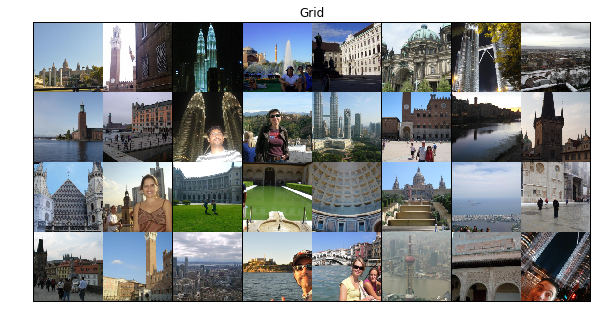

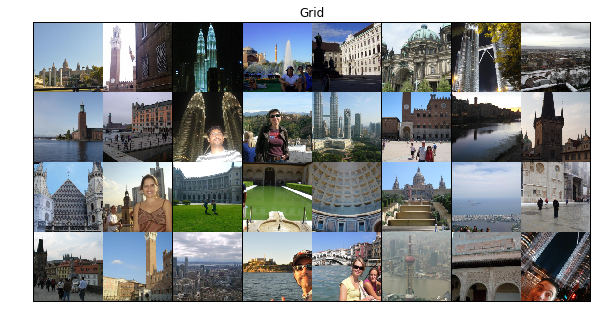

In [16]:
visualize_model(vgg16) #test before training

Not really great results. Let's see if it can do better after training

# **Training**
What follows is pretty standard pytorch code for training.

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with loss.backward() and optimizer.step(). Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset)

In [0]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10, visual_step = 100):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    accuracies = {x: [] for x in [TRAIN, VAL]}
    losses = {x: [] for x in [TRAIN, VAL]}
    training_loss = []
    training_acc = []
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs), end='\n')
        print('-' * 20)
        
        loss_train = 0
        loss_train_intermediar = 0
        acc_train = 0
        acc_train_intermediar = 0
        num_exam_train = 0
        num_exam_train_intermediar = 0
        
        vgg.train(True)
        
        print("TRAINING")
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % visual_step == 0:
                print("Training batch {}/{}".format(i, train_batches), end='\n')
                
            inputs, labels = data
            
            with torch.no_grad():
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            loss_train_intermediar += loss.item()
            acc_train += torch.sum(preds == labels.data)
            acc_train_intermediar += torch.sum(preds == labels.data)
            num_exam_train += inputs.shape[0] # can be different from BATCH_SIZE for the last batch
            num_exam_train_intermediar += inputs.shape[0]
            
            if i % visual_step == 0:
                
#                 accuracies[TRAIN].append(float(acc_train_intermediar) * 100 / num_exam_train_intermediar)
                training_loss.append(loss_train_intermediar / num_exam_train_intermediar)
                training_acc.append(float(acc_train_intermediar) * 100 / num_exam_train_intermediar)
                
                print("Avg loss per {} - {} batch (train) {}".format(i+1, i+visual_step, loss_train_intermediar / num_exam_train_intermediar), end='\n')
                print("Avg acc per  {} - {} batch (train) {}%".format(i+1, i+visual_step, float(acc_train_intermediar) * 100 / num_exam_train_intermediar), end='\n')
                loss_train_intermediar = 0
                acc_train_intermediar = 0
                num_exam_train_intermediar = 0
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss = loss_train / num_exam_train
        avg_acc = float(acc_train) / num_exam_train
        
        print()
        print("Epoch {} result: ".format(epoch + 1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        
        print()
        print()
        print("MESURE ACCURACY ON TRAIN AND VALIDATION")
        
        loss_train = 0
        loss_train_intermediar = 0
        loss_val = 0
        loss_val_intermediar = 0
        acc_train = 0
        acc_train_intermediar = 0
        acc_val = 0
        acc_val_intermediar = 0
        num_exam_train = 0
        num_exam_val = 0
        num_exam_train_intermediar = 0
        num_exam_val_intermediar = 0
        
        vgg.train(False)
        vgg.eval()
        
        #evaluate model on TRAIN
        for i, data in enumerate(dataloaders[TRAIN]):
            
            if i > val_batches:
                break
         
            if i % visual_step == 0:
                print("Train batch {}/{}".format(i, val_batches), end='\n')
                
            inputs, labels = data
            
            with torch.no_grad():
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
            
                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            
            loss_train += loss.item()
            loss_train_intermediar += loss.item()
            acc_train += torch.sum(preds == labels.data)
            acc_train_intermediar += torch.sum(preds == labels.data)
            num_exam_train += inputs.shape[0] # can be different from BATCH_SIZE for the last batch
            num_exam_train_intermediar += inputs.shape[0]
            
            if i % visual_step == 0:
                print("Avg loss per {} - {} batch (train) {}".format(i+1, i+visual_step, loss_train_intermediar / num_exam_train_intermediar), end='\n')
                print("Avg acc per  {} - {} batch (train) {}%".format(i+1, i+visual_step, float(acc_train_intermediar) * 100 / num_exam_train_intermediar), end='\n')
                loss_val_intermediar = 0
                acc_val_intermediar = 0
                num_exam_val_intermediar = 0
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_train = loss_train / num_exam_train
        avg_acc_train = float(acc_train) * 100 / num_exam_train
        losses[TRAIN].append(avg_loss_train)
        accuracies[TRAIN].append(avg_acc_train)
        
        #evaluate model on VALIDATION
        for i, data in enumerate(dataloaders[VAL]):
            if i % visual_step == 0:
                print("Validation batch {}/{}".format(i, val_batches), end='\n')
                
            inputs, labels = data
            
            with torch.no_grad():
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
            
                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            loss_val_intermediar += loss.item()
            acc_val += torch.sum(preds == labels.data)
            acc_val_intermediar += torch.sum(preds == labels.data)
            num_exam_val += inputs.shape[0] # can be different from BATCH_SIZE for the last batch
            num_exam_val_intermediar += inputs.shape[0]
            
            if i % visual_step == 0:
                print("Avg loss per {} - {} batch (val) {}".format(i+1, i+visual_step, loss_val_intermediar / num_exam_val_intermediar), end='\n')
                print("Avg acc per  {} - {} batch (val) {}%".format(i+1, i+visual_step, float(acc_val_intermediar) * 100 / num_exam_val_intermediar), end='\n')
                loss_val_intermediar = 0
                acc_val_intermediar = 0
                num_exam_val_intermediar = 0
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / num_exam_val
        avg_acc_val = float(acc_val) * 100 / num_exam_val
        losses[VAL].append(avg_loss_val)
        accuracies[VAL].append(avg_acc_val)
        
        print()
        print("Epoch {} result: ".format(epoch + 1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}%".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}%".format(avg_acc_val))
        print('-' * 20)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}%".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg, accuracies, losses, training_acc, training_loss

In [12]:
vgg16, accuracies, losses, training_acc, training_loss = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1, visual_step = 100)
torch.save(vgg16.state_dict(), data_dir_drive + '/VGG16_v4_all_dataset_1epoch_attention_other_scores.pt')

Epoch 1/1
--------------------
TRAINING
Training batch 0/3856


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Avg loss per 1 - 100 batch (train) 0.10298621654510498
Avg acc per  1 - 100 batch (train) 3.125%
Training batch 100/3856
Avg loss per 101 - 200 batch (train) 0.10297953113913536
Avg acc per  101 - 200 batch (train) 4.46875%
Training batch 200/3856
Avg loss per 201 - 300 batch (train) 0.10295250974595546
Avg acc per  201 - 300 batch (train) 6.875%
Training batch 300/3856
Avg loss per 301 - 400 batch (train) 0.1029143600165844
Avg acc per  301 - 400 batch (train) 8.46875%
Training batch 400/3856
Avg loss per 401 - 500 batch (train) 0.10284114614129067
Avg acc per  401 - 500 batch (train) 9.0%
Training batch 500/3856
Avg loss per 501 - 600 batch (train) 0.10267356887459755
Avg acc per  501 - 600 batch (train) 10.5%
Training batch 600/3856
Avg loss per 601 - 700 batch (train) 0.10158408001065254
Avg acc per  601 - 700 batch (train) 9.9375%
Training batch 700/3856
Avg loss per 701 - 800 batch (train) 0.1011167211830616
Avg acc per  701 - 800 batch (train) 10.09375%
Training batch 800/3856
A

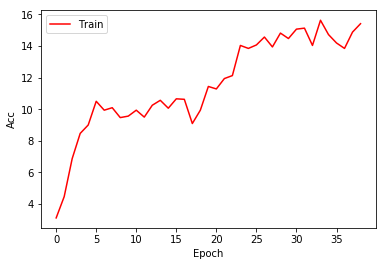

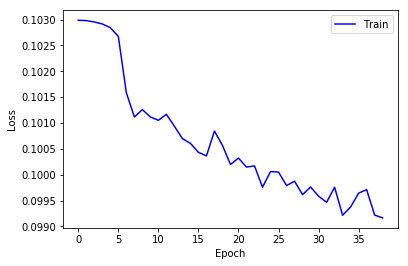

In [16]:

def plot_train_acc(acc):
    """
    Plots training/validation accuracies.
    """
    plt.figure()
    plt.plot(acc, c='r', label='Train')
    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_train_acc(training_acc)

def plot_train_losses(losses):
    """
    Plots training/validation accuracies.
    """
    plt.figure()
    plt.plot(losses, c='b', label='Train')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_train_losses(training_loss)

# **Model evaluation and visualization (after training)**
Let's evaluate our model again after 2 epochs of training

In [19]:
eval_model(vgg16, criterion)

Evaluating model
--------------------
Test batch 0/827


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss batch 0.09466936439275742
Avg acc per 1 - 100 batch (test) 31.25%
Test batch 100/827
Loss batch 0.0960036838799715
Avg acc per 101 - 200 batch (test) 27.8125%
Test batch 200/827
Loss batch 0.0958595572412014
Avg acc per 201 - 300 batch (test) 27.4375%
Test batch 300/827
Loss batch 0.09612725436687469
Avg acc per 301 - 400 batch (test) 26.34375%
Test batch 400/827
Loss batch 0.09559140443801879
Avg acc per 401 - 500 batch (test) 28.4375%
Test batch 500/827
Loss batch 0.09604593448340892
Avg acc per 501 - 600 batch (test) 27.09375%
Test batch 600/827
Loss batch 0.09572793886065484
Avg acc per 601 - 700 batch (test) 28.03125%
Test batch 700/827
Loss batch 0.09559576004743577
Avg acc per 701 - 800 batch (test) 28.5625%
Test batch 800/827
Loss batch 0.09601063035428524
Avg acc per 801 - 900 batch (test) 27.3125%

Evaluation completed in 3m 52s
Avg loss (test): 0.0959
Avg acc (test): 27.6696%
--------------------


Now that's a pretty good result!

Ground truth:
Prediction:


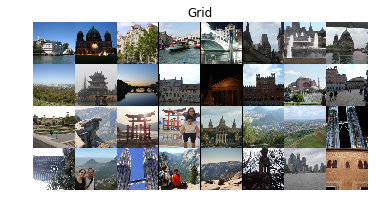

In [20]:
visualize_model(vgg16, num_images=32)

In [0]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

def mkdir_p(path):
    '''make dir if not exist'''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

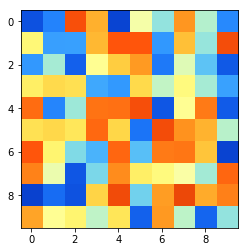

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

# functions to show an image
def make_image(img, mean=(0,0,0), std=(1,1,1)):
    for i in range(0, 3):
        img[i] = img[i] * std[i] + mean[i]    # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def gauss(x,a,b,c):
    return torch.exp(-torch.pow(torch.add(x,-b),2).div(2*c*c)).mul(a)

def colorize(x):
    ''' Converts a one-channel grayscale image to a color heatmap image '''
    if x.dim() == 2:
        torch.unsqueeze(x, 0, out=x)
    if x.dim() == 3:
        cl = torch.zeros([3, x.size(1), x.size(2)])
        cl[0] = gauss(x,.5,.6,.2) + gauss(x,1,.8,.3)
        cl[1] = gauss(x,1,.5,.3)
        cl[2] = gauss(x,1,.2,.3)
        cl[cl.gt(1)] = 1
    elif x.dim() == 4:
        cl = torch.zeros([x.size(0), 3, x.size(2), x.size(3)])
        cl[:,0,:,:] = gauss(x,.5,.6,.2) + gauss(x,1,.8,.3)
        cl[:,1,:,:] = gauss(x,1,.5,.3)
        cl[:,2,:,:] = gauss(x,1,.2,.3)
    return cl

def show_batch(images, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.imshow(images)
    plt.show()


def show_mask_single(images, mask, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(2, 1, 1)
    plt.imshow(images)
    plt.axis('off')

    # for b in range(mask.size(0)):
    #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
    mask_size = mask.size(2)
    # print('Max %f Min %f' % (mask.max(), mask.min()))
    mask = (upsampling(mask, scale_factor=im_size/mask_size))
    # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
    # for c in range(3):
    #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

    # print(mask.size())
    mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
    # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
    plt.subplot(2, 1, 2)
    plt.imshow(mask)
    plt.axis('off')

def show_mask(images, masklist, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(1+len(masklist), 1, 1)
    plt.imshow(images)
    plt.axis('off')

    for i in range(len(masklist)):
        mask = masklist[i].data.cpu()
        # for b in range(mask.size(0)):
        #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
        mask_size = mask.size(2)
        # print('Max %f Min %f' % (mask.max(), mask.min()))
        mask = (upsampling(mask, scale_factor=im_size/mask_size))
        # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
        # for c in range(3):
        #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

        # print(mask.size())
        mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
        # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
        plt.subplot(1+len(masklist), 1, i+2)
        plt.imshow(mask)
        plt.axis('off')


x = torch.rand(1, 10, 10)
out = colorize(x)
out_im = make_image(out)
plt.imshow(out_im)
plt.show()

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders[TEST]))

vgg16.train(False)
vgg16.eval()
        
with torch.no_grad():
    if use_gpu:
        inputs, classes = inputs.cuda(), classes.cuda()            

        outputs, attention_map = vgg16.forward_plus_attentionMap(inputs)
        
_, preds = torch.max(outputs.data, 1)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


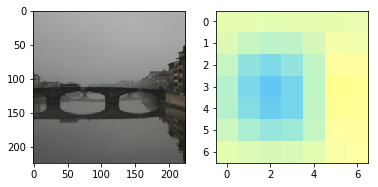

In [12]:
i = 0
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

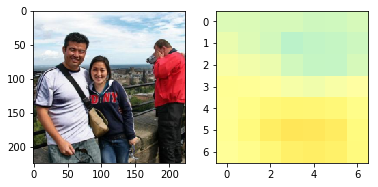

In [13]:
i = 1
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

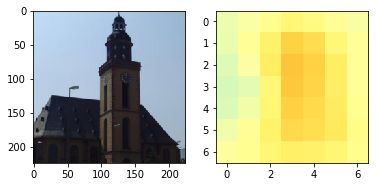

In [14]:
i = 2
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

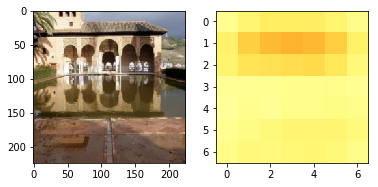

In [15]:
i = 3
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

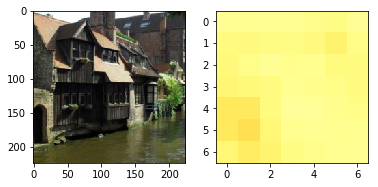

In [16]:
i = 4
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

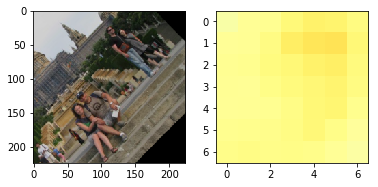

In [106]:
i = 5
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

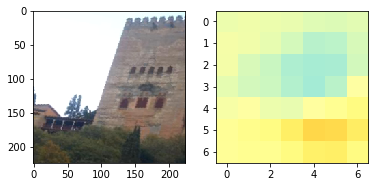

In [107]:
i = 6
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

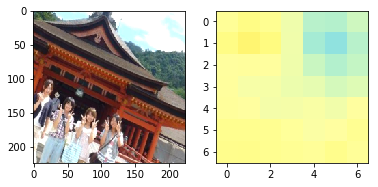

In [108]:
i = 7
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

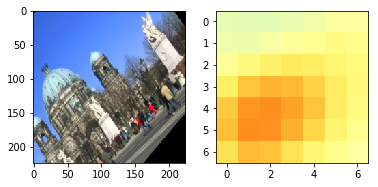

In [109]:
i = 8
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

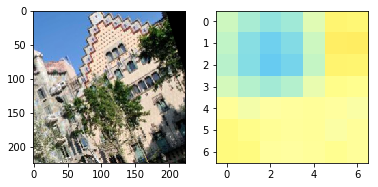

In [110]:
i = 9
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

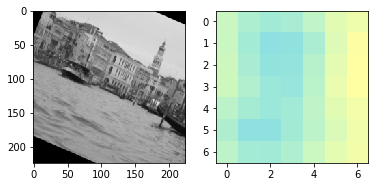

In [111]:
i = 10
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

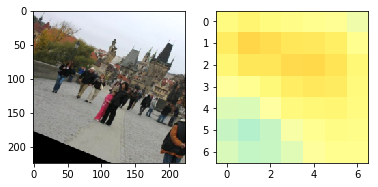

In [112]:
i = 11
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

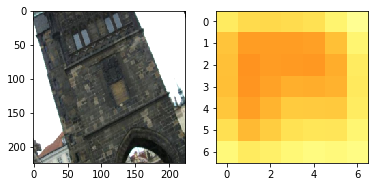

In [113]:
i = 12
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

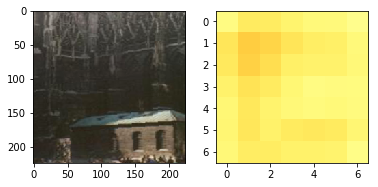

In [114]:
i = 13
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

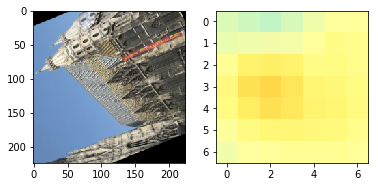

In [115]:
i = 14
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

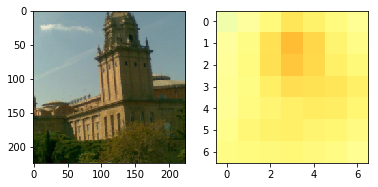

In [116]:
i = 15
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

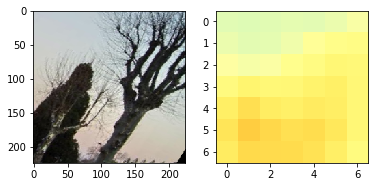

In [121]:
i = 16
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

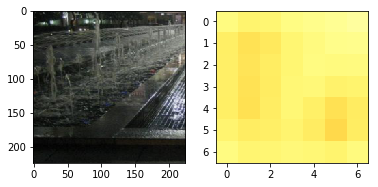

In [120]:
i = 17
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

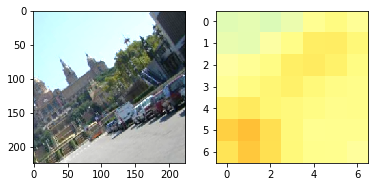

In [119]:
i = 18
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

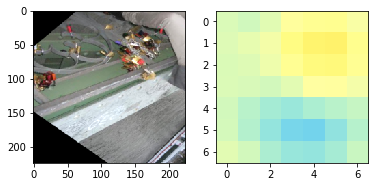

In [118]:
i = 19
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

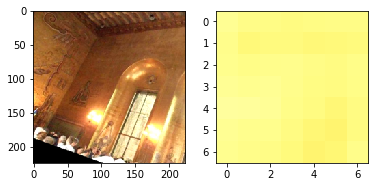

In [117]:
i = 20
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

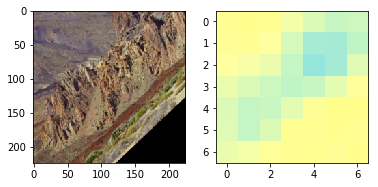

In [124]:
i = 21
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

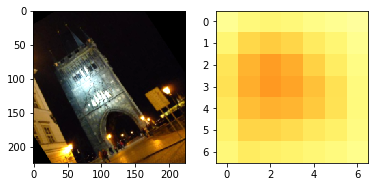

In [123]:
i = 22
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

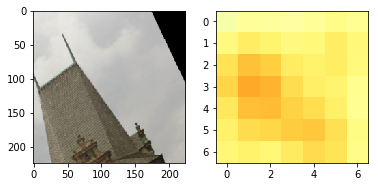

In [122]:
i = 23
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

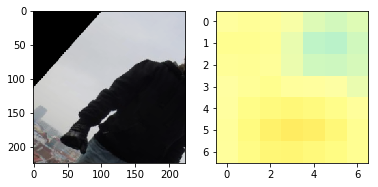

In [125]:
i = 24
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

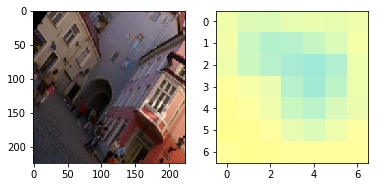

In [126]:
i = 25
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

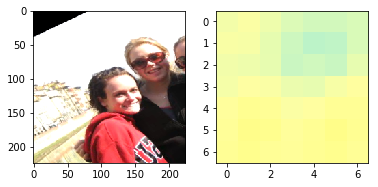

In [132]:
i = 26
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

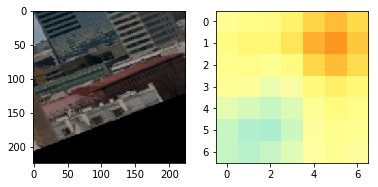

In [131]:
i = 27
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

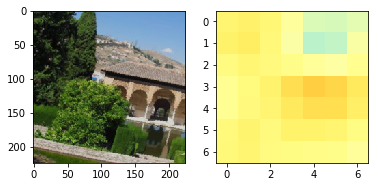

In [130]:
i = 28
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

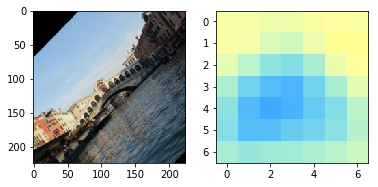

In [129]:
i = 29
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

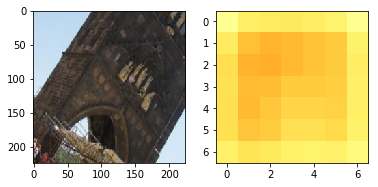

In [128]:
i = 30
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))

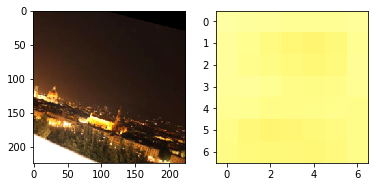

In [127]:
i = 31
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inputs[i].cpu().numpy().transpose((1, 2, 0)))
axarr[1].imshow(make_image(colorize(attention_map[i])))